<a href="https://colab.research.google.com/github/21Ovi/TensorFlow_/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from imblearn.over_sampling import RandomOverSampler,SMOTENC,SMOTE
from sklearn.feature_selection import SelectKBest,chi2
from sklearn import svm, tree, model_selection, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from yellowbrick.classifier import ROCAUC

!pip install optuna
import optuna
import matplotlib
import joblib

# To avoid warnings
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 KB 11.9 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=7205170e1d9aefbeffee87d74d3416e083d10bd138274afe4dc3aab4990848f8
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  

In [3]:
data = pd.read_excel('/content/preprocessed_data.xlsx')
data.head()

,Age,Distance From Home,Employee Hourly Rate,Number of Companies Worked,Employee Last Salary Hike Percent,Total Work Experience In Years,Training Times Last Year,Experience Years At This Company,Experience Years In Current Role,Years Since Last Promotion,...,Employee Work Life Balance,Gender,Education Background,Marital Status,Employees Department,Employees Job Role,Business Travel Frequency,Over Time,Attrition,Performance Rating
0,32,10,55,1,12,10,2,10,7,0.000000,...,2,1,2,2,5,13,2,0,0,3
1,47,14,42,2,12,20,2,7,7,1.000000,...,3,1,2,2,5,13,2,0,0,3
2,40,5,48,5,21,20,2,18,13,1.000000,...,3,1,1,1,5,13,1,1,0,4
3,41,10,73,3,15,23,2,21,6,3.464102,...,2,1,0,0,3,8,2,0,0,3
4,60,16,84,8,14,10,1,2,2,1.414214,...,3,1,2,2,5,13,2,0,0,3


# Feature Selection

In [4]:
# Splitting dataset into Dependent(X) and Independent(y) Variables

X = data.drop('Performance Rating', axis=1)
y = data['Performance Rating']

In [5]:
bestfeatures = SelectKBest(score_func=chi2,k=15)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featurescores = pd.concat([dfcolumns,dfscores],axis=1)
featurescores.columns = ['feature_names','Scores']

print(featurescores.nlargest(5,'Scores'))

                        feature_names       Scores
4   Employee Last Salary Hike Percent  1251.369985
12  Employee Environment Satisfaction   456.884207
9          Years Since Last Promotion   352.363603
7    Experience Years At This Company   347.864952
8    Experience Years In Current Role   347.401176


These are the `Top 5 features` which impact on the `target variable` to `predict the rating`.

## Checking which Machine Learning Algorithm perform well for given dataset

In [8]:
features = data.columns[:-1]
# test.rename({'':'Performance Rating'},axis = 1, inplace = True)

In [9]:
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # General Linear Models
    linear_model.LogisticRegression(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),

    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    # XGBOOST
    XGBClassifier()
]

In [10]:
# Split dataset in cross-validation with this splitter class
# note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = 0.3, train_size = 0.7, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%


#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data['Performance Rating']

In [11]:
# Index through MLA and save performance to table
row_index = 0
data1 = data.copy()
for alg in MLA:
    data = data1
    # Set name and parameters
    MLA_name = alg.__class__.__name__
    print('Executing ',MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # Score model with cross validation
    cv_results = model_selection.cross_validate(alg, data[features], data['Performance Rating'], cv  = cv_split)
    # Print(cv_results.keys())
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    # MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    # If this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    # Save MLA predictions - see section 6 for usage
    alg.fit(data[features], data['Performance Rating'])
    MLA_predict[MLA_name] = alg.predict(data[features])
    row_index+=1

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
# MLA_predict

Executing  AdaBoostClassifier
Executing  BaggingClassifier
Executing  ExtraTreesClassifier
Executing  GradientBoostingClassifier
Executing  RandomForestClassifier
Executing  LogisticRegression
Executing  PassiveAggressiveClassifier
Executing  RidgeClassifierCV
Executing  SGDClassifier
Executing  Perceptron
Executing  BernoulliNB
Executing  GaussianNB
Executing  KNeighborsClassifier
Executing  SVC
Executing  NuSVC
Executing  LinearSVC
Executing  DecisionTreeClassifier
Executing  ExtraTreeClassifier
Executing  LinearDiscriminantAnalysis
Executing  QuadraticDiscriminantAnalysis
Executing  XGBClassifier


,MLA Name,MLA Parameters,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.986404,0.016177,0.297566
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.985896,0.019396,0.318358
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.974587,0.015624,1.424325
16,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.971919,0.022191,0.013175
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.971792,0.020372,0.119827
20,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.968361,0.013472,0.440698
17,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.924524,0.056622,0.005014
19,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.860356,0.044567,0.012753
18,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.803431,0.028681,0.018058
7,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.802922,0.027827,0.029324


## Model training with all features
* By passing all features columns as X and performance rating (Target variable as Y).
* For Test data, model is getting `Accuracy score : 98%`.

While passing all feature, model is getting `98% accuracy`, Model might be overfitting & it will increases the complexity of model. So, we will pass selected features by applying feature selection technique.

In [12]:
X = data.drop('Performance Rating', axis=1)
y = data['Performance Rating']

In [13]:
train = X.loc[:,['Employee Last Salary Hike Percent','Employee Environment Satisfaction',
                       'Experience Years At This Company','Experience Years In Current Role','Years Since Last Promotion']]
test = y

# Spliting the dataset for training and test purpose

In [14]:
X_train,X_test,y_train,y_test = train_test_split(train,test,random_state=42,test_size=0.30)

In [15]:
len(train), len(test)

(2622, 2622)

# Machine Learning Algorithms

## ExtraTreeClassifier

In [16]:
# Initilize model
ext_clf = ExtraTreesClassifier() # random forest with default parameters
ext_clf.fit(X_train,y_train)
y_predict = ext_clf.predict(X_test)
y_train.value_counts()

3    624
4    615
2    596
Name: Performance Rating, dtype: int64

In [17]:
print(f"\033[1mTest accuracy_score : {round(accuracy_score(y_test,y_predict)*100,2)} %\n")
print("Test Classification Report\n")
print(classification_report(y_test,y_predict))

Test accuracy_score : 95.55 %

Test Classification Report

              precision    recall  f1-score   support

           2       0.92      0.99      0.95       278
           3       0.98      0.88      0.93       250
           4       0.97      1.00      0.98       259

    accuracy                           0.96       787
   macro avg       0.96      0.95      0.95       787
weighted avg       0.96      0.96      0.95       787



### Checking train accuracy to observe overfitting

In [18]:
train_predict = ext_clf.predict(X_train)
print(f"\033[1mTrain accuracy_score : {round(accuracy_score(y_train,train_predict)*100,2)} %\n")
print("Train Classification Report\n")
print(classification_report(y_train,train_predict))

Train accuracy_score : 98.69 %

Train Classification Report

              precision    recall  f1-score   support

           2       0.98      1.00      0.99       596
           3       0.99      0.97      0.98       624
           4       0.99      1.00      0.99       615

    accuracy                           0.99      1835
   macro avg       0.99      0.99      0.99      1835
weighted avg       0.99      0.99      0.99      1835



Here, difference between train accuracy and test accuracy is `least`. So we can say that the model is `not overfitted`.

## Evaluation

In [19]:
print(f"\033[1mTest accuracy_score : {round(accuracy_score(y_test,y_predict)*100,2)} %\n")
print("Train Classification Report\n")
print(classification_report(y_test,y_predict))

Test accuracy_score : 95.55 %

Train Classification Report

              precision    recall  f1-score   support

           2       0.92      0.99      0.95       278
           3       0.98      0.88      0.93       250
           4       0.97      1.00      0.98       259

    accuracy                           0.96       787
   macro avg       0.96      0.95      0.95       787
weighted avg       0.96      0.96      0.95       787



## RandomForestClassifier

In [20]:
# Initilize model
rf = RandomForestClassifier() # random forest with default parameters
rf.fit(X_train,y_train)
y_predict = rf.predict(X_test)
y_train.value_counts()

3    624
4    615
2    596
Name: Performance Rating, dtype: int64

### Evaluation

In [21]:
print(f"\033[1mTest accuracy_score : {round(accuracy_score(y_test,y_predict)*100,2)} %\n")
print("Train Classification Report\n")
print(classification_report(y_test,y_predict))

Test accuracy_score : 96.06 %

Train Classification Report

              precision    recall  f1-score   support

           2       0.93      0.99      0.96       278
           3       0.98      0.89      0.94       250
           4       0.97      1.00      0.98       259

    accuracy                           0.96       787
   macro avg       0.96      0.96      0.96       787
weighted avg       0.96      0.96      0.96       787



In [22]:
train_predict = rf.predict(X_train)
print(f"\033[1mTrain accuracy_score : {round(accuracy_score(y_train,train_predict)*100,2)} %\n")
print("Train Classification Report\n")
print(classification_report(y_train,train_predict))

Train accuracy_score : 98.69 %

Train Classification Report

              precision    recall  f1-score   support

           2       0.98      1.00      0.99       596
           3       0.99      0.97      0.98       624
           4       0.99      1.00      0.99       615

    accuracy                           0.99      1835
   macro avg       0.99      0.99      0.99      1835
weighted avg       0.99      0.99      0.99      1835



* Here, difference between train accuracy & test accuracy is `least`. SO we can say that nidek is `not overfitted`.
* The accuracy of `RandomForestClassifier model` is `less` compared to `ExtraTreeClassifier model`, So we should focus on `ExtraTreeClassifier model`.

# Feature Scaling

In [23]:
scaler = StandardScaler()
X2 = scaler.fit_transform(train)
X2 = pd.DataFrame(X2)
X2.columns = ['Employee Last Salary Hike Percent',
       'Employee Environment Satisfaction', 'Experience Years At This Company',
       'Experience Years In Current Role', 'Years Since Last Promotion']

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X2,y,random_state=42,test_size=0.30)

# ExtraTreeClassifier model after Feature Scaling

In [25]:
# Initialize model
ext_clf1 = ExtraTreesClassifier()
ext_clf1.fit(X_train, y_train)
y_predict = ext_clf1.predict(X_test)
y_train.value_counts()

3    624
4    615
2    596
Name: Performance Rating, dtype: int64

## Evaluation

In [26]:
print(f"\033[1mTest accuracy_score : {round(accuracy_score(y_test,y_predict)*100,2)} %\n")
print("Test Classification Report\n")
print(classification_report(y_test,y_predict))

Test accuracy_score : 95.81 %

Test Classification Report

              precision    recall  f1-score   support

           2       0.92      0.99      0.95       278
           3       0.98      0.88      0.93       250
           4       0.98      1.00      0.99       259

    accuracy                           0.96       787
   macro avg       0.96      0.96      0.96       787
weighted avg       0.96      0.96      0.96       787



After feature scaling, test accuract `slightly increased`

In [27]:
train_predict = ext_clf1.predict(X_train)
print(f"\033[1mTrain accuracy_score : {round(accuracy_score(y_train,train_predict)*100,2)} %\n")
print("Train Classification Report\n")
print(classification_report(y_train,train_predict))

Train accuracy_score : 98.69 %

Train Classification Report

              precision    recall  f1-score   support

           2       0.98      1.00      0.99       596
           3       0.99      0.97      0.98       624
           4       0.99      1.00      0.99       615

    accuracy                           0.99      1835
   macro avg       0.99      0.99      0.99      1835
weighted avg       0.99      0.99      0.99      1835



Here, difference between train accuracy & test accuracy is `less, so model is not overfit`.

# Hyperparameter Tunning

In [28]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        #'max_depth': int(trial.suggest_float('max_depth', 10, 100, log=True)),
        'min_samples_split': trial.suggest_int('min_sample_split', 2, 6),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6,),
        'max_features': trial.suggest_categorical('max_features',["auto", "sqrt", "log2"]),
        'bootstrap':trial.suggest_categorical('bootstrap',[True,False]),
        'random_state': trial.suggest_int('random_state', 0, 100)
        #'scale_pos_weight': 0.48,
       }
        
    clf = ExtraTreesClassifier(**params)
    auccuracies = []
    X_train_k = X_train.values
    y_train_k = y_train.values
    kf = KFold(n_splits=3,random_state=None,shuffle=True)
    for train_idx, valid_idx in kf.split(X_train_k,y_train_k):
        train_data = X_train_k[train_idx, :], y_train_k[train_idx]
        valid_data = X_train_k[valid_idx, :], y_train_k[valid_idx]
        
        clf.fit(X_train_k[train_idx, :], y_train_k[train_idx])
        pred = clf.predict(X_train_k[valid_idx, :])
        accuracy = accuracy_score(y_train_k[valid_idx],pred)
        auccuracies.append(accuracy)
    print(f'Trial done: Accuracy values on folds: {auccuracies}')
    return np.average(auccuracies)

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

n_trials = 51

#FIT_XGB = True

#if FIT_XGB:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-01-05 02:30:45,567] A new study created in memory with name: no-name-81336a8f-c36a-475b-af1a-45d06b2b29d8
[I 2023-01-05 02:30:50,260] Trial 0 finished with value: 0.8888193575302461 and parameters: {'n_estimators': 829, 'min_sample_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'random_state': 20}. Best is trial 0 with value: 0.8888193575302461.


Trial done: Accuracy values on folds: [0.8986928104575164, 0.8954248366013072, 0.8723404255319149]


[I 2023-01-05 02:30:54,696] Trial 1 finished with value: 0.9465892194302707 and parameters: {'n_estimators': 889, 'min_sample_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 49}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.946078431372549, 0.9558823529411765, 0.9378068739770867]


[I 2023-01-05 02:31:04,390] Trial 2 finished with value: 0.9422301380999754 and parameters: {'n_estimators': 1683, 'min_sample_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': False, 'random_state': 94}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9362745098039216, 0.9558823529411765, 0.9345335515548282]


[I 2023-01-05 02:31:10,783] Trial 3 finished with value: 0.8773841233165388 and parameters: {'n_estimators': 1213, 'min_sample_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True, 'random_state': 11}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.8823529411764706, 0.8725490196078431, 0.8772504091653028]


[I 2023-01-05 02:31:12,543] Trial 4 finished with value: 0.8719321516568076 and parameters: {'n_estimators': 333, 'min_sample_split': 5, 'min_samples_leaf': 6, 'max_features': 'auto', 'bootstrap': True, 'random_state': 83}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.869281045751634, 0.8790849673202614, 0.867430441898527]


[I 2023-01-05 02:31:15,730] Trial 5 finished with value: 0.9117237002093073 and parameters: {'n_estimators': 711, 'min_sample_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'bootstrap': False, 'random_state': 81}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9019607843137255, 0.9084967320261438, 0.9247135842880524]


[I 2023-01-05 02:31:25,022] Trial 6 finished with value: 0.937336200164736 and parameters: {'n_estimators': 1683, 'min_sample_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': False, 'random_state': 60}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9411764705882353, 0.9215686274509803, 0.9492635024549918]


[I 2023-01-05 02:31:28,184] Trial 7 finished with value: 0.9117112202218585 and parameters: {'n_estimators': 569, 'min_sample_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'random_state': 67}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.8905228758169934, 0.9428104575163399, 0.9018003273322422]


[I 2023-01-05 02:31:33,140] Trial 8 finished with value: 0.8970008807305426 and parameters: {'n_estimators': 1152, 'min_sample_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False, 'random_state': 53}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.8888888888888888, 0.9084967320261438, 0.8936170212765957]


[I 2023-01-05 02:31:44,825] Trial 9 finished with value: 0.9416917157843315 and parameters: {'n_estimators': 1998, 'min_sample_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': True, 'random_state': 45}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9411764705882353, 0.9379084967320261, 0.9459901800327333]


[I 2023-01-05 02:31:46,068] Trial 10 finished with value: 0.9177149856123573 and parameters: {'n_estimators': 268, 'min_sample_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'random_state': 28}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9264705882352942, 0.9019607843137255, 0.9247135842880524]


[I 2023-01-05 02:31:53,583] Trial 11 finished with value: 0.9427756918370185 and parameters: {'n_estimators': 1531, 'min_sample_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 96}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9313725490196079, 0.9607843137254902, 0.9361702127659575]


[I 2023-01-05 02:32:00,253] Trial 12 finished with value: 0.9367817321509436 and parameters: {'n_estimators': 1395, 'min_sample_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'random_state': 38}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.946078431372549, 0.9330065359477124, 0.9312602291325696]


[I 2023-01-05 02:32:07,437] Trial 13 finished with value: 0.9269778105823162 and parameters: {'n_estimators': 1498, 'min_sample_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'random_state': 100}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9281045751633987, 0.9215686274509803, 0.9312602291325696]


[I 2023-01-05 02:32:12,441] Trial 14 finished with value: 0.9422292466723005 and parameters: {'n_estimators': 911, 'min_sample_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 72}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9607843137254902, 0.9330065359477124, 0.9328968903436988]


[I 2023-01-05 02:32:17,459] Trial 15 finished with value: 0.9335119754393847 and parameters: {'n_estimators': 1073, 'min_sample_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'random_state': 37}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9411764705882353, 0.9313725490196079, 0.9279869067103109]


[I 2023-01-05 02:32:26,171] Trial 16 finished with value: 0.8969928578814687 and parameters: {'n_estimators': 1946, 'min_sample_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'random_state': 6}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.8954248366013072, 0.9166666666666666, 0.8788870703764321]


[I 2023-01-05 02:32:28,535] Trial 17 finished with value: 0.9084494863593737 and parameters: {'n_estimators': 519, 'min_sample_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'random_state': 55}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9035947712418301, 0.9084967320261438, 0.9132569558101473]


[I 2023-01-05 02:32:35,088] Trial 18 finished with value: 0.9362326127032009 and parameters: {'n_estimators': 1326, 'min_sample_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 85}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9493464052287581, 0.9362745098039216, 0.9230769230769231]


[I 2023-01-05 02:32:42,629] Trial 19 finished with value: 0.9280680266287274 and parameters: {'n_estimators': 1629, 'min_sample_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'random_state': 70}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.934640522875817, 0.9166666666666666, 0.9328968903436988]


[I 2023-01-05 02:32:46,732] Trial 20 finished with value: 0.8888291632346701 and parameters: {'n_estimators': 944, 'min_sample_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False, 'random_state': 44}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9019607843137255, 0.8741830065359477, 0.8903436988543372]


[I 2023-01-05 02:32:55,390] Trial 21 finished with value: 0.9411470534749634 and parameters: {'n_estimators': 1773, 'min_sample_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': False, 'random_state': 100}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9281045751633987, 0.9493464052287581, 0.9459901800327333]


[I 2023-01-05 02:33:02,794] Trial 22 finished with value: 0.9384192847897479 and parameters: {'n_estimators': 1505, 'min_sample_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': False, 'random_state': 89}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.946078431372549, 0.9313725490196079, 0.9378068739770867]


[I 2023-01-05 02:33:11,058] Trial 23 finished with value: 0.9286117975104208 and parameters: {'n_estimators': 1782, 'min_sample_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': False, 'random_state': 92}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9281045751633987, 0.9264705882352942, 0.9312602291325696]


[I 2023-01-05 02:33:17,274] Trial 24 finished with value: 0.9422381609490497 and parameters: {'n_estimators': 1280, 'min_sample_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 62}. Best is trial 1 with value: 0.9465892194302707.


Trial done: Accuracy values on folds: [0.9297385620915033, 0.9477124183006536, 0.9492635024549918]


[I 2023-01-05 02:33:23,439] Trial 25 finished with value: 0.9471383388780135 and parameters: {'n_estimators': 1239, 'min_sample_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 65}. Best is trial 25 with value: 0.9471383388780135.


Trial done: Accuracy values on folds: [0.9444444444444444, 0.9509803921568627, 0.9459901800327333]


[I 2023-01-05 02:33:29,152] Trial 26 finished with value: 0.9226151635413213 and parameters: {'n_estimators': 1023, 'min_sample_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'random_state': 29}. Best is trial 25 with value: 0.9471383388780135.


Trial done: Accuracy values on folds: [0.9199346405228758, 0.9264705882352942, 0.9214402618657938]


[I 2023-01-05 02:33:32,570] Trial 27 finished with value: 0.9117174602155829 and parameters: {'n_estimators': 759, 'min_sample_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'random_state': 77}. Best is trial 25 with value: 0.9471383388780135.


Trial done: Accuracy values on folds: [0.9183006535947712, 0.9035947712418301, 0.9132569558101473]


[I 2023-01-05 02:33:39,769] Trial 28 finished with value: 0.9449534496468163 and parameters: {'n_estimators': 1464, 'min_sample_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 75}. Best is trial 25 with value: 0.9471383388780135.


Trial done: Accuracy values on folds: [0.9558823529411765, 0.9444444444444444, 0.9345335515548282]


[I 2023-01-05 02:33:45,857] Trial 29 finished with value: 0.8937248840252594 and parameters: {'n_estimators': 1113, 'min_sample_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'random_state': 62}. Best is trial 25 with value: 0.9471383388780135.


Trial done: Accuracy values on folds: [0.9183006535947712, 0.8839869281045751, 0.8788870703764321]


[I 2023-01-05 02:33:49,831] Trial 30 finished with value: 0.924247367614076 and parameters: {'n_estimators': 852, 'min_sample_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'random_state': 48}. Best is trial 25 with value: 0.9471383388780135.


Trial done: Accuracy values on folds: [0.9150326797385621, 0.9395424836601307, 0.9181669394435352]


[I 2023-01-05 02:33:57,163] Trial 31 finished with value: 0.9498607589971795 and parameters: {'n_estimators': 1480, 'min_sample_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 79}. Best is trial 31 with value: 0.9498607589971795.


Trial done: Accuracy values on folds: [0.9575163398692811, 0.9477124183006536, 0.9443535188216039]


[I 2023-01-05 02:34:04,222] Trial 32 finished with value: 0.9427783661200433 and parameters: {'n_estimators': 1431, 'min_sample_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 75}. Best is trial 31 with value: 0.9498607589971795.


Trial done: Accuracy values on folds: [0.9362745098039216, 0.9509803921568627, 0.9410801963993454]


[I 2023-01-05 02:34:13,206] Trial 33 finished with value: 0.946049905686952 and parameters: {'n_estimators': 1288, 'min_sample_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 69}. Best is trial 31 with value: 0.9498607589971795.


Trial done: Accuracy values on folds: [0.9558823529411765, 0.934640522875817, 0.9476268412438625]


[I 2023-01-05 02:34:19,442] Trial 34 finished with value: 0.9444203758972219 and parameters: {'n_estimators': 1235, 'min_sample_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 57}. Best is trial 31 with value: 0.9498607589971795.


Trial done: Accuracy values on folds: [0.9248366013071896, 0.9526143790849673, 0.955810147299509]


[I 2023-01-05 02:34:25,019] Trial 35 finished with value: 0.9187953959543447 and parameters: {'n_estimators': 994, 'min_sample_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'random_state': 66}. Best is trial 31 with value: 0.9498607589971795.


Trial done: Accuracy values on folds: [0.9215686274509803, 0.9264705882352942, 0.9083469721767594]


[I 2023-01-05 02:34:30,932] Trial 36 finished with value: 0.9427765832646934 and parameters: {'n_estimators': 1189, 'min_sample_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 82}. Best is trial 31 with value: 0.9498607589971795.


Trial done: Accuracy values on folds: [0.9428104575163399, 0.9477124183006536, 0.9378068739770867]


[I 2023-01-05 02:34:36,580] Trial 37 finished with value: 0.9013742249036367 and parameters: {'n_estimators': 1303, 'min_sample_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False, 'random_state': 65}. Best is trial 31 with value: 0.9498607589971795.


Trial done: Accuracy values on folds: [0.8986928104575164, 0.8823529411764706, 0.9230769230769231]


[I 2023-01-05 02:34:39,874] Trial 38 finished with value: 0.9013617449161879 and parameters: {'n_estimators': 593, 'min_sample_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'random_state': 51}. Best is trial 31 with value: 0.9498607589971795.


Trial done: Accuracy values on folds: [0.9052287581699346, 0.8986928104575164, 0.900163666121113]


[I 2023-01-05 02:34:50,878] Trial 39 finished with value: 0.9275197986086597 and parameters: {'n_estimators': 1616, 'min_sample_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'random_state': 79}. Best is trial 31 with value: 0.9498607589971795.


Trial done: Accuracy values on folds: [0.9199346405228758, 0.9362745098039216, 0.9263502454991817]


[I 2023-01-05 02:34:54,318] Trial 40 finished with value: 0.8926382336895479 and parameters: {'n_estimators': 772, 'min_sample_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False, 'random_state': 58}. Best is trial 31 with value: 0.9498607589971795.


Trial done: Accuracy values on folds: [0.9019607843137255, 0.8921568627450981, 0.88379705400982]


[I 2023-01-05 02:35:01,133] Trial 41 finished with value: 0.9504143355832967 and parameters: {'n_estimators': 1373, 'min_sample_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 71}. Best is trial 41 with value: 0.9504143355832967.


Trial done: Accuracy values on folds: [0.9477124183006536, 0.9428104575163399, 0.9607201309328969]


[I 2023-01-05 02:35:07,921] Trial 42 finished with value: 0.9525840705440204 and parameters: {'n_estimators': 1371, 'min_sample_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 87}. Best is trial 42 with value: 0.9525840705440204.


Trial done: Accuracy values on folds: [0.9656862745098039, 0.9477124183006536, 0.9443535188216039]


[I 2023-01-05 02:35:14,842] Trial 43 finished with value: 0.943873039304829 and parameters: {'n_estimators': 1401, 'min_sample_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 85}. Best is trial 42 with value: 0.9525840705440204.


Trial done: Accuracy values on folds: [0.9395424836601307, 0.9411764705882353, 0.9509001636661211]


[I 2023-01-05 02:35:20,628] Trial 44 finished with value: 0.9422292466723005 and parameters: {'n_estimators': 1154, 'min_sample_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 89}. Best is trial 42 with value: 0.9525840705440204.


Trial done: Accuracy values on folds: [0.9526143790849673, 0.9411764705882353, 0.9328968903436988]


[I 2023-01-05 02:35:28,520] Trial 45 finished with value: 0.9465892194302707 and parameters: {'n_estimators': 1596, 'min_sample_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 71}. Best is trial 42 with value: 0.9525840705440204.


Trial done: Accuracy values on folds: [0.954248366013072, 0.9477124183006536, 0.9378068739770867]


[I 2023-01-05 02:35:36,756] Trial 46 finished with value: 0.9307931210309183 and parameters: {'n_estimators': 1771, 'min_sample_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'random_state': 72}. Best is trial 42 with value: 0.9525840705440204.


Trial done: Accuracy values on folds: [0.9248366013071896, 0.9313725490196079, 0.9361702127659575]


[I 2023-01-05 02:35:44,674] Trial 47 finished with value: 0.942781040403068 and parameters: {'n_estimators': 1344, 'min_sample_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'random_state': 19}. Best is trial 42 with value: 0.9525840705440204.


Trial done: Accuracy values on folds: [0.9575163398692811, 0.9248366013071896, 0.9459901800327333]


[I 2023-01-05 02:35:50,246] Trial 48 finished with value: 0.9247929213511191 and parameters: {'n_estimators': 1212, 'min_sample_split': 6, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': False, 'random_state': 82}. Best is trial 42 with value: 0.9525840705440204.


Trial done: Accuracy values on folds: [0.9264705882352942, 0.9281045751633987, 0.9198036006546645]


[I 2023-01-05 02:35:50,854] Trial 49 finished with value: 0.9444230501802466 and parameters: {'n_estimators': 117, 'min_sample_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'random_state': 95}. Best is trial 42 with value: 0.9525840705440204.


Trial done: Accuracy values on folds: [0.9477124183006536, 0.9248366013071896, 0.9607201309328969]


[I 2023-01-05 02:35:58,407] Trial 50 finished with value: 0.9498643247078791 and parameters: {'n_estimators': 1525, 'min_sample_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'random_state': 44}. Best is trial 42 with value: 0.9525840705440204.


Trial done: Accuracy values on folds: [0.9477124183006536, 0.9509803921568627, 0.9509001636661211]
Number of finished trials: 51
Best trial:
  Value: 0.9525840705440204
  Params: 
    n_estimators: 1371
    min_sample_split: 3
    min_samples_leaf: 1
    max_features: log2
    bootstrap: False
    random_state: 87


## ExtraTreesClassifier with best parameters after Hyperparameter Tunning

In [29]:
ec1 = ExtraTreesClassifier(
    n_estimators= 103,
    max_depth= None,
    min_samples_split=3,
    min_samples_leaf= 1,
    max_features= 'log2',
    max_leaf_nodes= None,
    bootstrap= False,
    random_state=42)
ec1.fit(X_train,y_train)
y_predict3 = ec1.predict(X_test)
y_train.value_counts()

3    624
4    615
2    596
Name: Performance Rating, dtype: int64

## Evaluation

In [30]:
print(f"\033[1mTest accuracy score : {round(accuracy_score(y_test,y_predict3)*100,2)} %\n")
print("Test Classification Report\n")
print(classification_report(y_test,y_predict3))

Test accuracy score : 95.81 %

Test Classification Report

              precision    recall  f1-score   support

           2       0.92      0.99      0.95       278
           3       0.98      0.88      0.93       250
           4       0.98      1.00      0.99       259

    accuracy                           0.96       787
   macro avg       0.96      0.96      0.96       787
weighted avg       0.96      0.96      0.96       787



In [31]:
train_predict3 = ec1.predict(X_train)
print(f"\033[1mTrain accuracy_score : {round(accuracy_score(y_train,train_predict)*100,2)} %\n")
print("Train Classification Report\n")
print(classification_report(y_train,train_predict))

Train accuracy_score : 98.69 %

Train Classification Report

              precision    recall  f1-score   support

           2       0.98      1.00      0.99       596
           3       0.99      0.97      0.98       624
           4       0.99      1.00      0.99       615

    accuracy                           0.99      1835
   macro avg       0.99      0.99      0.99      1835
weighted avg       0.99      0.99      0.99      1835



It is found that after hyperparameter tunning, test accuracy `remains same & model is not overfitted`.

# Confusion Matrix

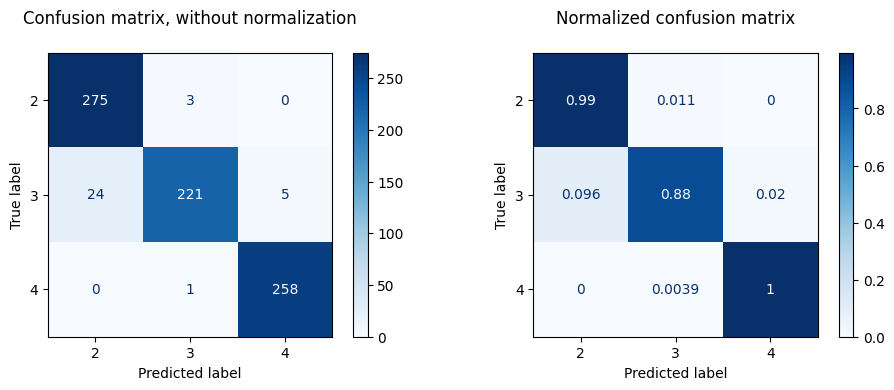

In [32]:
# Default theame for plotings
matplotlib.rcdefaults()
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
# Plot non-normalized confusion matrix
cm1 = plot_confusion_matrix(ec1, X_test, y_test, cmap=plt.cm.Blues,normalize=None,ax=ax1)
cm1.ax_.set_title("Confusion matrix, without normalization\n",fontsize=12)

cm2 = plot_confusion_matrix(ec1, X_test, y_test, cmap=plt.cm.Blues,normalize="true",ax=ax2)
cm2.ax_.set_title("Normalized confusion matrix\n",fontsize=12)
plt.tight_layout(pad=2)

plt.show();

# ROC Curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate. False Positive Rate.

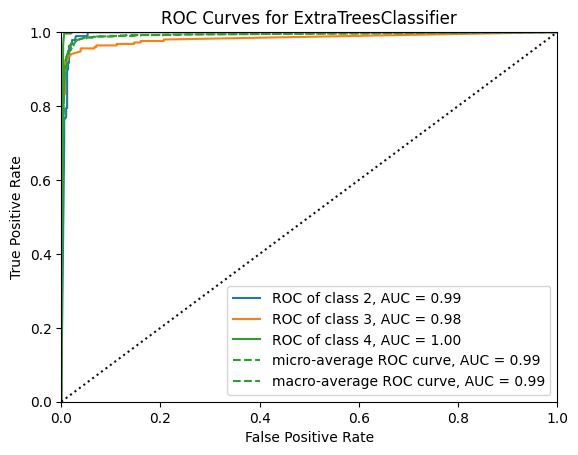

In [33]:
# Instaniate the classification model and visualizer
model = ExtraTreesClassifier(
    n_estimators= 999,
    max_depth= None,
    min_samples_split=3,
    min_samples_leaf= 1,
    max_features= 'log2',
    max_leaf_nodes= None,
    bootstrap= False,
    random_state=42)

visualizer = ROCAUC(model) #model=ec1

visualizer.fit(X_train, y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 
plt.show()
# Finalize and render the figure

# Conclusion


* ExtraTreesClassifier model work well for given dataset.
* Test accuracy of this model is `95.81%`.
* Train accuracy of this model is `98.69%`.
* ROC for class 2{Good Performance Rating} is `99%`.
* ROC for class 3{Excellent Performance Rating} is `98%`.
* ROC for class 4{Outstanding Performance Rating} is `100%`.

# Saving the model

In [34]:
joblib.dump(model, "trained_model.sav")

['trained_model.sav']